In [1]:
import pykx as kx
import numpy as np

In [2]:
kx.q('system"c 200 250"')

pykx.Identity(pykx.q('::'))

In [3]:
complete = kx.q.read.csv('complete.csv', types='PJFFFFFFFFFJFJJF', delimiter=',', as_table=True)

In [4]:
final = kx.q.qsql.select(complete, where=['WEEKDAY<5','9<HOUR','HOUR<20'])

In [5]:
# where only accepts either strings or a list of strings. it's a shame bc there is a kx.q.fby function
final = kx.q.qsql.select(final, where='40 <= (avg;traffic_load) fby traffic_station')

In [6]:
final = kx.q.qsql.update(final, columns={'traffic_load': 'traffic_load%100'})

In [7]:
def time_window(train_or_test, station, df):
    op = "#" if train_or_test == "train" else "_"
    data = kx.q.qsql.select(df, 
                            columns={'rainfall': '(count[i]-80)' + op + 'rainfall',
                                     'temperature': '(count[i]-80)' + op + 'temperature',
                                     'traffic_load': '(count[i]-80)' + op + 'traffic_load',
                                     'HOUR': '(count[i]-80)' + op + 'HOUR',
                                     'WEEKDAY': '(count[i]-80)' + op + 'WEEKDAY'}, 
                            by='traffic_station')
    toMatrix = kx.q("{({[t;i]value t[i]}[x;]')til count x:flip x}")
    sw = kx.q("{({y#z _x}[x;5;]')til count b:6 _x}")
    gl = kx.q("{6_(flip x)[`traffic_load]}")
    index = kx.q('{x[' + str(station) + ']}')
    X = np.array(index(kx.q.each(sw, kx.q.each(toMatrix, data))).py())
    y = np.array(index(kx.q.each(gl, data)))
    return (X, y)

In [8]:
train_X, train_y = time_window("train", 3403, final)
test_X, test_y = time_window("test", 3403, final)

In [9]:
test_X

array([[[ 0.    , 10.    ,  0.45  , 14.    ,  1.    ],
        [ 0.    , 10.4   ,  0.4525, 15.    ,  1.    ],
        [ 0.    , 10.3   ,  0.4775, 16.    ,  1.    ],
        [ 0.    , 10.    ,  0.54  , 17.    ,  1.    ],
        [ 0.    ,  9.9   ,  0.5225, 18.    ,  1.    ]],

       [[ 0.    , 10.4   ,  0.4525, 15.    ,  1.    ],
        [ 0.    , 10.3   ,  0.4775, 16.    ,  1.    ],
        [ 0.    , 10.    ,  0.54  , 17.    ,  1.    ],
        [ 0.    ,  9.9   ,  0.5225, 18.    ,  1.    ],
        [ 0.    , 10.    ,  0.55  , 19.    ,  1.    ]],

       [[ 0.    , 10.3   ,  0.4775, 16.    ,  1.    ],
        [ 0.    , 10.    ,  0.54  , 17.    ,  1.    ],
        [ 0.    ,  9.9   ,  0.5225, 18.    ,  1.    ],
        [ 0.    , 10.    ,  0.55  , 19.    ,  1.    ],
        [ 0.    , 10.6   ,  0.4275, 10.    ,  2.    ]],

       ...,

       [[ 0.    , 12.6   ,  0.5   , 11.    ,  4.    ],
        [ 0.    , 13.2   ,  0.4875, 12.    ,  4.    ],
        [ 0.    , 13.6   ,  0.4775, 13.    ,  

In [10]:
test_y

array([0.4275, 0.475 , 0.435 , 0.54  , 0.51  , 0.4725, 0.4725, 0.495 ,
       0.4775, 0.4625, 0.465 , 0.495 , 0.475 , 0.4525, 0.5175, 0.5175,
       0.6325, 0.4925, 0.5075, 0.545 , 0.485 , 0.4725, 0.4825, 0.51  ,
       0.2825, 0.35  , 0.4075, 0.495 , 0.375 , 0.3525, 0.26  , 0.2725,
       0.29  , 0.38  , 0.4975, 0.6   , 0.445 , 0.5475, 0.575 , 0.375 ,
       0.3625, 0.4625, 0.56  , 0.4425, 0.4425, 0.5225, 0.4775, 0.5525,
       0.47  , 0.4425, 0.3125, 0.1   , 0.48  , 0.3425, 0.5675, 0.415 ,
       0.4425, 0.4275, 0.575 , 0.445 , 0.435 , 0.44  , 0.4725, 0.5125,
       0.4875, 0.5   , 0.4875, 0.4775, 0.3875, 0.42  , 0.4275, 0.5025,
       0.375 , 0.4975])

Epoch 1/3
2/2 [==============================] - 5s 1s/step - loss: 0.5343 - val_loss: 0.3738
Epoch 2/3
2/2 [==============================] - 0s 116ms/step - loss: 0.2703 - val_loss: 0.1998
Epoch 3/3
2/2 [==============================] - 0s 114ms/step - loss: 0.2093 - val_loss: 0.1329


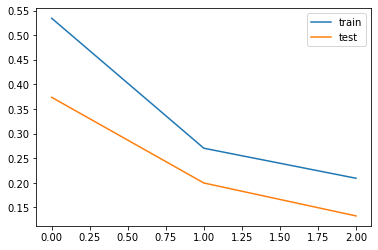

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
# design network
model = Sequential()

#model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]))
model.add(LSTM(units = 500, return_sequences=True, input_shape=[5,5]))
model.add(LSTM(units = 250,return_sequences=True))
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=3, batch_size=64, validation_split=0.2, verbose=1, shuffle=False)
#history2 = model.fit(train_X2, train_y2, epochs=20, batch_size=64, validation_data=(test_X2, test_y2), verbose=1, shuffle=False)
#history3 = model.fit(train_X3, train_y3, epochs=20, batch_size=64, validation_data=(test_X3, test_y3), verbose=1, shuffle=False)
#history4 = model.fit(train_X4, train_y4, epochs=20, batch_size=64, validation_data=(test_X4, test_y4), verbose=1, shuffle=False)
# plot history
#plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'], label='train')
#plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']+ history4.history['val_loss'], label='test')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [13]:
model.predict(train_X)

4/4 [==============================] - 1s 20ms/step


array([[0.3152508 ],
       [0.32095337],
       [0.32640648],
       [0.3324599 ],
       [0.33877677],
       [0.34497833],
       [0.3521846 ],
       [0.3555123 ],
       [0.35287595],
       [0.3427632 ],
       [0.3212469 ],
       [0.32685673],
       [0.33174682],
       [0.3370826 ],
       [0.34324172],
       [0.34931225],
       [0.35405093],
       [0.35439992],
       [0.34880134],
       [0.33575302],
       [0.31094798],
       [0.3187054 ],
       [0.32541412],
       [0.33141783],
       [0.33659554],
       [0.3412005 ],
       [0.3441401 ],
       [0.34352216],
       [0.33848467],
       [0.3279165 ],
       [0.30925256],
       [0.3170446 ],
       [0.32384273],
       [0.33000022],
       [0.33558396],
       [0.34054434],
       [0.3442421 ],
       [0.34404063],
       [0.33950025],
       [0.32925406],
       [0.3106548 ],
       [0.31732017],
       [0.32333612],
       [0.3293837 ],
       [0.33568874],
       [0.34177622],
       [0.34729227],
       [0.349